In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


train_data = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')
train_data.head()


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [7]:
print(train_data.shape[0])
print(len(train_data['ImageId'].unique()))
train_data = train_data.dropna()
print(train_data.shape[0])
print(len(train_data['ImageId'].unique()))

81723
42556
81723
42556


In [8]:
#train_data = train_data.fillna('0')
train_data = train_data.groupby("ImageId")["EncodedPixels"].agg(EncodedPixels = lambda x: " ".join(map(str,  x)))
train_data.reset_index("ImageId", inplace = True)
train_data = train_data.to_numpy()

In [10]:
print(train_data[0:20])

[['000155de5.jpg'
  '264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33

In [3]:
import cv2
import os

train_image_dir = '/kaggle/input/airbus-ship-detection/train_v2/'

def decode_ep(enc_pix):
#        "Enc_pix - encoded pixels: string"
#        "Splitting string into separate integers"
        enc_pix = np.asarray(enc_pix.split(), dtype = np.uint32)
        
#        "Each odd number is start pixel, even number - a difference between "
#        "start and end pixel"
        num_of_pix = np.array(enc_pix[::2])
        rep_of_pix = np.array(enc_pix[1::2])
#       "Len of all arrray"
        end = len(num_of_pix)
        arr_of_pix = [np.asarray(
          np.arange(num_of_pix[i], num_of_pix[i] + rep_of_pix[i]))
                  for i in range(end)]
#        "resolution of image is 768 by 768"
        size = 768
#        "concatenating the separable arrays of decoded pixels"
        rle = np.concatenate(arr_of_pix)
        rle -= 1
        square = np.power(size, 2)
        
        plot_mask = np.zeros(square, dtype = np.uint8)
#        "As encoded pixels marks a ship, we can make a high contrast"
#        "between ship and sea or land(i.e no-ship zone)"
        plot_mask[rle] = 255
        plot_mask = np.reshape(plot_mask, (size, size)).T
        plot_mask = plot_mask / 255
        return plot_mask 

def train_gererator(tup, batch_size = None):
    """
    tup: tuple or list containing names with corresponding encoded pixels
    """
#    "We have to use generator due to large dataset"
    out_rgb = []
    out_mask = []
    while True:
        for c_img_id, c_masks in tup:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = cv2.imread(rgb_path)
            c_mask = np.expand_dims(decode_ep(c_masks), -1)
#            "Reduction of resolution from 768x768 to 256x256"
            c_img = c_img[::3, ::3]
            c_mask = c_mask[::3, ::3]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [4]:

#making a train data to fit U-net and valid data to test model
train_data[:5000]
valid_data = train_data[5000:5125]
valid_gen = train_gererator(valid_data, 125)
valid_x, valid_y = next(valid_gen)

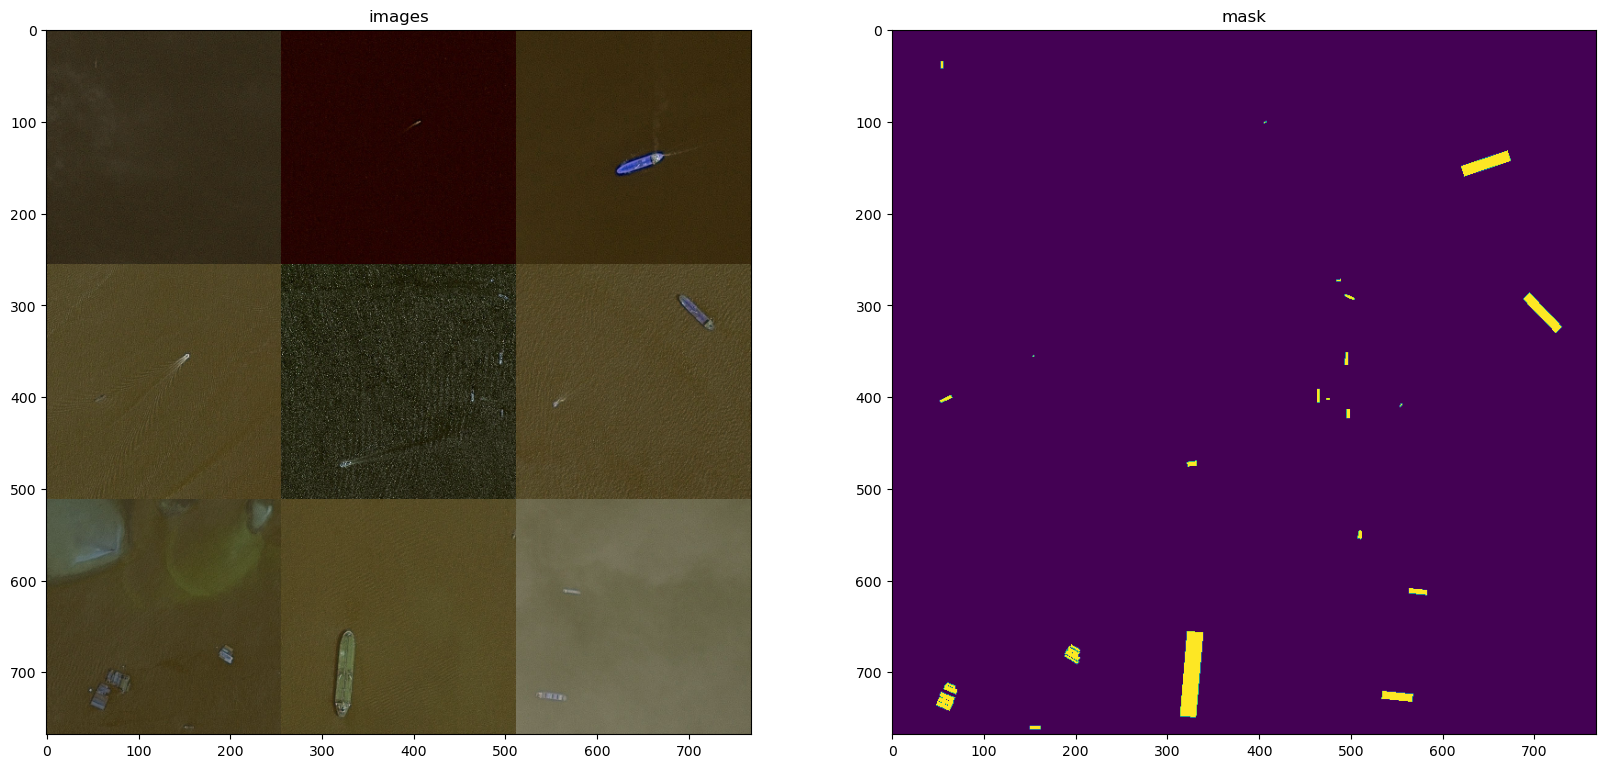

In [5]:
import matplotlib.pyplot as plt
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)


t_x = valid_x[:9]
t_y = valid_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x))
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]))
ax2.set_title('mask')
fig.savefig('ships.png')




In [6]:
print('x', valid_x.shape, valid_x.min(), valid_x.max())
print('y', valid_y.shape, valid_y.min(), valid_y.max())

x (125, 256, 256, 3) 0.0 1.0
y (125, 256, 256, 1) 0.0 1.0


In [7]:
from keras import Sequential, Model
from keras import layers
from keras import Input


def build_model(input_layer):


    conv1 = layers.Conv2D(8, (3, 3), activation="relu", padding = 'same')(input_layer)
    conv1 = layers.Conv2D(8, (3, 3), activation="relu", padding = 'same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    pool1 = layers.Dropout(0.5)(pool1)

    conv2 = layers.Conv2D(16, (3, 3), activation="relu", padding = 'same')(pool1)
    conv2 = layers.Conv2D(16, (3, 3), activation="relu", padding = 'same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    pool2 = layers.Dropout(0.5)(pool2)

    conv3 = layers.Conv2D(32, (3, 3), activation="relu", padding = 'same')(pool2)
    conv3 = layers.Conv2D(32, (3, 3), activation="relu", padding = 'same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    pool3 = layers.Dropout(0.5)(pool3)

    conv4 = layers.Conv2D(64, (3, 3), activation="relu", padding = 'same')(pool3)
    conv4 = layers.Conv2D(64, (3, 3), activation="relu", padding = 'same')(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    pool4 = layers.Dropout(0.5)(pool4)

    convm = layers.Conv2D(128, (3, 3), activation="relu", padding = 'same')(pool4)
    convm = layers.Conv2D(128, (3, 3), activation="relu", padding = 'same')(convm)

    deconv4 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding = 'same')(convm)
    uconv4 = layers.concatenate([deconv4, conv4])
    uconv4 = layers.Dropout(0.5)(uconv4)
    uconv4 = layers.Conv2D(64, (3, 3), activation="relu", padding = 'same')(uconv4)
    uconv4 = layers.Conv2D(64, (3, 3), activation="relu", padding = 'same')(uconv4)

    deconv3 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding = 'same')(uconv4)
    uconv3 = layers.concatenate([deconv3, conv3])
    uconv3 = layers.Dropout(0.5)(uconv3)
    uconv3 = layers.Conv2D(32, (3, 3), activation="relu", padding = 'same')(uconv3)
    uconv3 = layers.Conv2D(32, (3, 3), activation="relu", padding = 'same')(uconv3)

    deconv2 = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding = 'same')(uconv3)
    uconv2 = layers.concatenate([deconv2, conv2])
    uconv2 = layers.Dropout(0.5)(uconv2)
    uconv2 = layers.Conv2D(16, (3, 3), activation="relu", padding = 'same')(uconv2)
    uconv2 = layers.Conv2D(16, (3, 3), activation="relu", padding = 'same')(uconv2)

    deconv1 = layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding = 'same')(uconv2)
    uconv1 = layers.concatenate([deconv1, conv1])
    uconv1 = layers.Dropout(0.5)(uconv1)
    uconv1 = layers.Conv2D(8, (3, 3), activation="relu", padding = 'same')(uconv1)
    uconv1 = layers.Conv2D(8, (3, 3), activation="relu", padding = 'same')(uconv1)
    output_layer = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((256, 256, 3))
output_layer = build_model(input_layer)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [8]:
model = Model(input_layer, output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv2d_1[0][0]']           

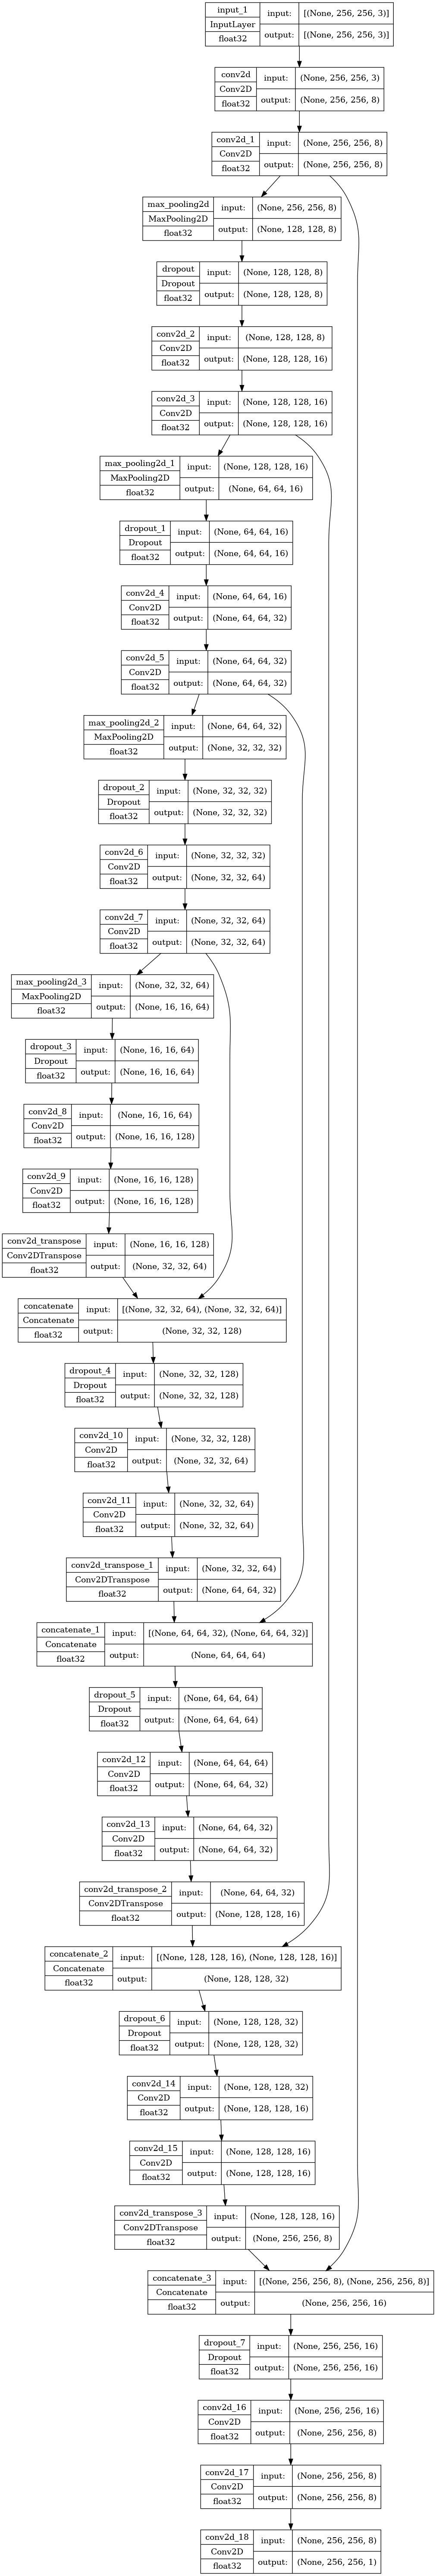

In [9]:
import keras
keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [10]:
import keras.backend as K

def DICE_score(y_true, y_pred, eps = 0.1):
    """
    y_true - real mask - numpy matrix 
    y_pred - predicted mask - Tensor
    eps - some small number to make smoothness of predict and avoiding case 0/0
    """
    y_true,y_pred  =K.flatten(y_true), K.flatten(y_pred)
    
    intersection=K.sum(y_true* y_pred)
    union  = K.sum(y_true*y_true) + K.sum(y_pred*y_pred)
    
    return(2* intersection + eps) / (union + eps)

def DICE_score_loss(y_true, y_pred):
    return 1-DICE_score(y_true, y_pred)


Importing

Se

In [11]:
from keras.preprocessing.image import ImageDataGenerator as IDG

#Setting the parameters of IDG
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

label_gen = IDG(**dg_args)

image_gen = IDG(**dg_args)


In [12]:
def create_gen(in_gen):
    """
    in_gen - tuple containing stacked images and corresponding
    stacked masks
    """
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        
        
        
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = image_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [14]:
from keras.optimizers import Adam

#Compiling the model
model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=DICE_score_loss, metrics=["binary_accuracy", DICE_score])


#End fitting it by train data
gen = create_gen(train_gererator(train_data, 16))
model.fit_generator(gen, steps_per_epoch=20,
                    epochs = 8, validation_data=(valid_x, valid_y))

/tmp/ipykernel_32/2722272743.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(gen, steps_per_epoch=20,


Epoch 1/8
20/20 [==============================] - 88s 4s/step - loss: 0.9818 - binary_accuracy: 0.9568 - DICE_score: 0.0182 - val_loss: 0.9771 - val_binary_accuracy: 0.9953 - val_DICE_score: 0.0229 - lr: 0.0010
Epoch 2/8
20/20 [==============================] - 86s 4s/step - loss: 0.9443 - binary_accuracy: 0.9927 - DICE_score: 0.0557 - val_loss: 0.8907 - val_binary_accuracy: 0.9952 - val_DICE_score: 0.1095 - lr: 0.0010
Epoch 3/8
20/20 [==============================] - 87s 4s/step - loss: 0.8807 - binary_accuracy: 0.9928 - DICE_score: 0.1193 - val_loss: 0.8162 - val_binary_accuracy: 0.9951 - val_DICE_score: 0.1831 - lr: 0.0010
Epoch 4/8
20/20 [==============================] - 86s 4s/step - loss: 0.7591 - binary_accuracy: 0.9930 - DICE_score: 0.2409 - val_loss: 0.5834 - val_binary_accuracy: 0.9938 - val_DICE_score: 0.4155 - lr: 0.0010
Epoch 5/8
20/20 [==============================] - 84s 4s/step - loss: 0.6318 - binary_accuracy: 0.9901 - DICE_score: 0.3682 - val_loss: 0.5825 - val_bi

1/1 [==============================] - 0s 96ms/step


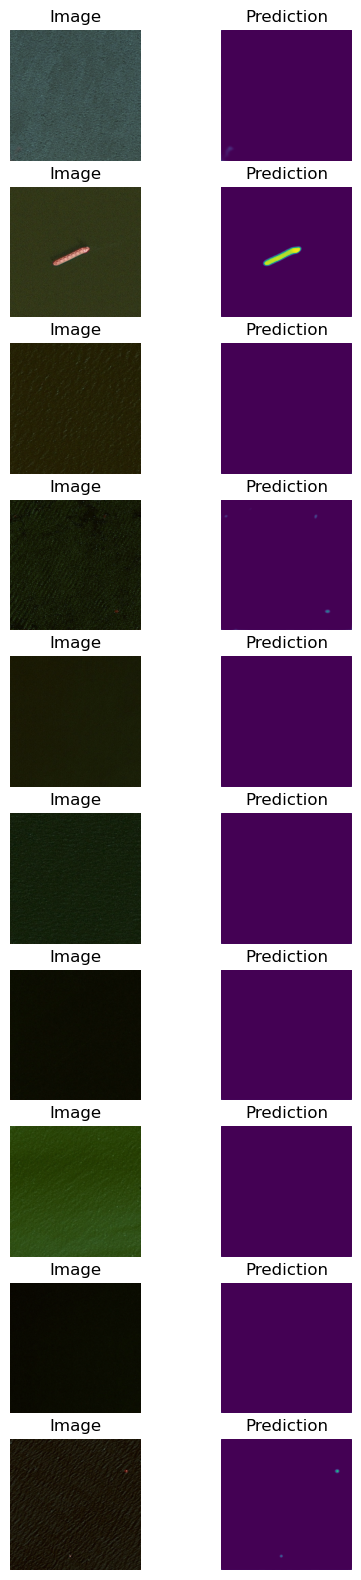

In [19]:
import cv2

test_paths = os.listdir('/kaggle/input/airbus-ship-detection/test_v2')

fig, m_axs = plt.subplots(10, 2)
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join('/kaggle/input/airbus-ship-detection/test_v2', c_img_name)
    c_img = cv2.imread(c_path)
    c_img = cv2.resize(c_img,(256,256))
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = model.predict(first_img)
    first_img[0][:,:,0] = (first_img[0][:,:,0]*0.7 + 0.5*first_seg[0, :, :, 0])
    result = np.array(np.clip(first_img[0]*255.,0,255),dtype=np.int32)
    ax1.imshow(result)
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')